<a href="https://colab.research.google.com/github/Colsai/scott_data606/blob/main/Topic_Modeling_Final/Topic_Modeling_Reports_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HHS OIG Reports** Topic Modeling (Step 2)
## Continued Topic Modeling for OIG Reports
*Description: A look through the current OIG work projects and group them using LDA. This uses a similar methodology and text cleaning strategy to the initial notebook*

## What is an OIG report?
- An OIG report includes the summary findings and conclusion of a particular work plan item, as well as recommendations for actions to be taken. *For example, this is an example of an audit report:*

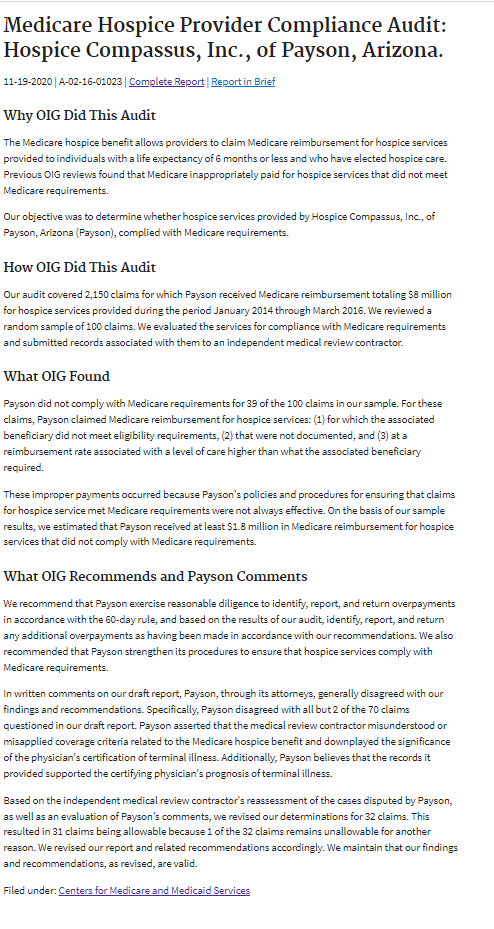

## Scope of 2nd Notebook:
This is a continuation of the exploration into topic modeling done with the notebook on OIG work plans.

In this notebook, we will look at the scraped, connected reports that OIG has collected from its reporting.

## Specific Questions on Work Plan Reports
1. How do OIG's Reports align with their original work plans?
2. From modeling, does the scope of the findings or the work change, and are there any new/distinctive findings that were not initially considered?

## Reports Topic Models Used:
1) **Latent Dirichilet Allocation (LDA) Model**  
2) **BerTopic Model**


In [1]:
from IPython.display import clear_output

In [2]:
#Install missing packages
!pip install pyLDAvis
!pip install bertopic
!pip install bertopic[visualization]
!python -m spacy download en_core_web_md -qq
clear_output()

In [3]:
###########################
# Import Packages         #
###########################
import pandas as pd
import sklearn
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim_models
import en_core_web_md
import gensim
import random
import pyLDAvis
from nltk.tokenize import RegexpTokenizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim import corpora, models
from gensim.test.utils import datapath
import warnings

warnings.filterwarnings('ignore')

# Set options for specific packages
nltk.download(['punkt', 
               'stopwords',
               'wordnet',
               'omw-1.4'])

# Visualise inside a notebook
pyLDAvis.enable_notebook()

sns.set()

clear_output()

In [4]:
###########################
# Load CSVs (Github)      #
###########################
reports_df = pd.read_csv("https://github.com/Colsai/scott_data606/blob/main/Data_Sources/HHS_OIG_Reports.csv?raw=true")

In [5]:
#Method to save LDA model to disk
'''
def save_model(path = '/content/drive/MyDrive/DATA_606/lda_model', 
               model = Lda_model):
    temp_file = datapath([path])
    model.save(temp_file)

# Load a potentially pretrained model from disk.
def load_model(path = ''):
    saved_model = LdaModel.load(path)
    return saved_model
'''

clear_output()

## Latent Dirichlet Allocation (LDA) Model
Topic model by cleaning text and running it through an LDA model.

In [6]:
reports_df.head()

,Unnamed: 0,Report Number(s),Workplan_Title,Workplan_Summary
0,0,A-02-17-02005,New York Did Not Have Adequate Oversight of It...,The Temporary Assistance for Needy Families (T...
1,1,A-02-16-02009,The Administration for Children and Families R...,The Administration for Children and Families (...
2,2,A-09-16-01004,The Administration for Children and Families R...,Head Start grantees are required to have Singl...
3,3,A-06-17-07003,The Administration for Children and Families D...,Head Start grantees are required to have Singl...
4,4,A-02-16-02013,"The Children's Village, Inc., an Administratio...",The Office of Refugee Resettlement (ORR) withi...


In [7]:
reports_df.dropna(inplace = True)

## LDA Step 1: Parse, Clean, and Tokenize text
- Set stopwords, add custom stopwords
- Remove Punctuation, tokenize and stem data
- Set series of lists of tokens and count of tokens

In [8]:
###########################
# Text Cleaning           #
###########################
from nltk.stem import RegexpStemmer

stopwords = nltk.corpus.stopwords.words('english')

#Add Stopwords (Add additional stopwords that were high-frequency)
stopwords.extend(['on',
                  'or', 
                  'to', 
                  'a', 
                  'as', 
                  'of', 
                  'for',
                  'this', 
                  'by', 
                  's',])

#Extend for specific/frequent hhs-related words
stopwords.extend(['oig',
                  'hhs',
                  'amp',
                  'asp'])

##############################
# Tokenize and Stemmer       #
##############################
#Set tokenizer as regex tokenizer to remove punctuation
regex_tokenizer = RegexpTokenizer(r'\w+')

wp_init_srs = [paragraph.lower() for paragraph in reports_df["Workplan_Summary"]]

tokenized_sums = [[i for i in regex_tokenizer.tokenize(sent) if i not in stopwords] 
                  for sent in wp_init_srs]

# Regex Stemmer (Other Stemmers didn't seem to work well)
Reg_stemmer = RegexpStemmer("ing$|s$|ies$")

tokenized_stemmed_sums = [[Reg_stemmer.stem(word) for word in sent] for sent in tokenized_sums]

# Set new column of tokenized summaries
reports_df["summary_tokenized"] = tokenized_stemmed_sums

reports_df["summary_token_num"] = [len(sent) for sent in tokenized_stemmed_sums]

## Model Score (Coherence)
- U_mass coherence score is a score of the frequency at which two words appear together. 
- Score Coherence of Model - u_mass coherence score
- (Consider also c_v, other scores)
See: https://www.baeldung.com/cs/topic-modeling-coherence-score

In [48]:
###############################
# LDA Data: Run LDA           #
###############################
dictionary = Dictionary(reports_df["summary_tokenized"])

#Filter extreme token values (no tokens below 5, no tokens in over 50% of documents)
dictionary.filter_extremes(no_below=5, 
                           no_above=0.5, 
                           keep_n=1000)

#Corpus from doc2bow
corpus = [dictionary.doc2bow(doc) for 
          doc in reports_df["summary_tokenized"]]

#lda model parameters
lda_model = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=200, 
                         num_topics=25,
                         workers = 8, 
                         passes=20)

In [10]:
#LDA Model Coherence Score
cm = CoherenceModel(model=lda_model, 
                    corpus=corpus, 
                    coherence="u_mass")

coherence = cm.get_coherence()  # get coherence value

print(coherence)

-1.649065130973492


In [11]:
#########################
# Test Number of Topics #
#########################
lda_umass_scores = []

for topic_num in range(1,30,4):
    #LDA model parameters
    lda_model = LdaMulticore(corpus=corpus, 
                            id2word=dictionary, 
                            iterations=200, 
                            num_topics=topic_num,
                            workers = None, 
                            passes=10)

    #LDA Model Coherence Score
    cm = CoherenceModel(model=lda_model, 
                        corpus=corpus, 
                        coherence="u_mass")
    
    # get coherence value
    coherence = cm.get_coherence()  
    print(f"Topics:{topic_num}, Coherence = {coherence}")
    
    #Save Coherence Values
    lda_umass_scores.append([topic_num, coherence])

Topics:1, Coherence = -1.1462361156050347
Topics:5, Coherence = -2.296856536096411
Topics:9, Coherence = -1.9944532122687333
Topics:13, Coherence = -2.0065987324742176
Topics:17, Coherence = -1.8271193413170763
Topics:21, Coherence = -1.747579409872021
Topics:25, Coherence = -1.685903225867277
Topics:29, Coherence = -1.7744186551078958


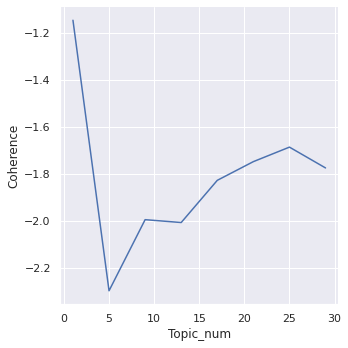

In [12]:
#Coherence Score Graphing
coherence_scores = pd.DataFrame(lda_umass_scores, 
                                columns = ['Topic_num',
                                           'Coherence'])

sns.relplot(data = coherence_scores, 
            kind="line",
            x = 'Topic_num', 
            y= 'Coherence')

### Run LDA
Using the cleaned data, run the LDA model on the summary tokens.
- Set dictionary as the tokens,
- Filter Extremes
- Set Corpus with Doc2bow
- Create LDA Model with Parameters

### Check Summaries
Let's take a look at how well the text parsing and tokenization worked

In [13]:
#Sample Summaries
sample_item = reports_df.sample(1)

print(sample_item["Workplan_Summary"].iloc[0])

print(sample_item["summary_tokenized"].iloc[0])

This report provides the results of our review of the Food and Drug Administration (FDA) Office of National Drug Control Policy (ONDCP) Budget Formulation Compliance Report, which includes budget formulation information for the fiscal year ending September 30, 2023, and the Chief Financial Officer's or accountable senior executive's assertions relating to the budget formulation information.  We performed this review as required by 21 U.S.C. section 1704(d)(1) and as authorized by 21 U.S.C. section 1703(d)(7) and in compliance with the ONDCP Circular National Drug Control Program Agency Compliance Reviews, dated September 9, 2021 (ONDCP Compliance Reviews Circular)., We also received FDA's ONDCP Detailed Accounting Report and management's assertions for the fiscal year ended September 30, 2021.  FDA did not provide this report in sufficient time for the Office of Inspector General to review and authenticate the report.  Accordingly, we do not express a conclusion about the reliability o

### LDA: Visualize and View Topics
*Use PyLDAvis to generate a visualization of the model*

In [14]:
#Visualize the model with pyLDAvis
lda_model_visualize = pyLDAvis.gensim_models.prepare(lda_model,
                                                     corpus = corpus, 
                                                     dictionary = dictionary)
lda_model_visualize

#Give context and explanation for the lambda relevance metric

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.176814 -0.070438       1        1  6.500986
18    -0.099020  0.054631       2        1  6.024465
24     0.095644 -0.060594       3        1  5.834648
2      0.115372 -0.004104       4        1  5.275059
17    -0.086063  0.116955       5        1  5.245502
13     0.135119 -0.111874       6        1  5.145698
27     0.025141  0.148325       7        1  4.996279
9      0.050286 -0.194248       8        1  4.549295
23     0.080315 -0.052335       9        1  4.469147
0      0.088072  0.101892      10        1  4.203353
25    -0.020833  0.113093      11        1  4.093083
19     0.149685 -0.048119      12        1  3.595940
16    -0.015374 -0.167013      13        1  3.507032
5     -0.240863 -0.268885      14        1  2.952985
8     -0.053254  0.097729      15        1  2.918274
6      0.080878 -0.013009      16        1  2.839583
22    -0.003087  0.106356      17        1  2.729910
26    -0.136488 -0.048187      18        1  2.645164
15     0.087373  0.075354      19        1  2.600739
11    -0.034130  0.081216      20        1  2.519099
3     -0.211638 -0.045492      21        1  2.440573
21     0.019208  0.009879      22        1  2.350615
20    -0.273444  0.045612      23        1  2.134764
4      0.049132  0.002890      24        1  2.057690
14     0.032316  0.115034      25        1  1.953842
7     -0.085207  0.042656      26        1  1.811330
28     0.096199 -0.091974      27        1  1.791171
1     -0.024503 -0.004895      28        1  1.446274
12     0.002349  0.069548      29        1  1.367499, topic_info=            Term         Freq        Total Category  logprob  loglift
688         drug  1106.000000  1106.000000  Default  30.0000  30.0000
301         cost   821.000000   821.000000  Default  29.0000  29.0000
79       payment  1380.000000  1380.000000  Default  28.0000  28.0000
993       opioid   362.000000   362.000000  Default  27.0000  27.0000
435        claim  1160.000000  1160.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
174        staff    10.348978   315.516903  Topic29  -4.9297   0.8749
772   beneficiar    11.315058   900.034931  Topic29  -4.8404  -0.0841
20         audit    11.195035   926.099158  Topic29  -4.8511  -0.1233
193         data    10.804187   835.323374  Topic29  -4.8866  -0.0557
362  information    10.112683   453.555692  Topic29  -4.9528   0.4889

[1519 rows x 6 columns], token_table=      Topic      Freq Term
term                      
201       1  0.008727  000
201       2  0.052364  000
201       3  0.052364  000
201       4  0.026182  000
201       5  0.026182  000
...     ...       ...  ...
659       4  0.063801    ½
659       9  0.212671    ½
659      20  0.361541    ½
659      24  0.085068    ½
659      27  0.255205    ½

[8638 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 19, 25, 3, 18, 14, 28, 10, 24, 1, 26, 20, 17, 6, 9, 7, 23, 27, 16, 12, 4, 22, 21, 5, 15, 8, 29, 2, 13])

In [15]:
#Topics Generated
for idx, topic in lda_model.print_topics():
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 3 
Words: 0.072*"drug" + 0.051*"part" + 0.037*"plan" + 0.034*"used" + 0.025*"eligible" + 0.021*"entit" + 0.015*"utilization" + 0.014*"management" + 0.014*"include" + 0.013*"tool"
Topic: 6 
Words: 0.033*"risk" + 0.024*"contract" + 0.023*"code" + 0.021*"diagnosi" + 0.020*"program" + 0.019*"payment" + 0.018*"diagnose" + 0.017*"care" + 0.016*"enrollee" + 0.014*"use"
Topic: 18 
Words: 0.029*"program" + 0.021*"beneficiar" + 0.021*"percent" + 0.019*"order" + 0.017*"patient" + 0.017*"event" + 0.015*"harm" + 0.013*"data" + 0.010*"2018" + 0.009*"use"
Topic: 23 
Words: 0.054*"state" + 0.031*"cost" + 0.027*"agency" + 0.025*"million" + 0.024*"payment" + 0.019*"hospital" + 0.018*"share" + 0.017*"system" + 0.014*"data" + 0.014*"unallowable"
Topic: 20 
Words: 0.156*"opioid" + 0.044*"use" + 0.034*"drug" + 0.033*"beneficiar" + 0.033*"prescription" + 0.031*"overdose" + 0.031*"data" + 0.029*"part" + 0.029*"state" + 0.028*"crisi"
Topic: 8 
Words: 0.052*"unit" + 0.031*"hospice" + 0.029*"case" + 0.024

In [19]:
#Eye Test (Classification Test)
n = random.randint(0,len(reports_df)) 

print(reports_df.iloc[n]['Workplan_Summary'], end = '')

for index, score in sorted(lda_model[corpus[n]], key=lambda tup: -1*tup[1]):

    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

The Department of Defense and Labor, Health and Human Services, and Education Appropriations Act, 2019, and Continuing Appropriations Act, 2019, P.L. No. 115-245, directed OIG to examine the efforts of the National Institutes of Health (NIH) to ensure the integrity of its grant application evaluation and recipient selection processes.  This audit is part of OIG's response to this directive.
Our objective was to determine whether the National Cancer Institute (NCI) had adequate policies and procedures in its pre-award process for assessing risk when awarding grant funds. , We obtained a list of all 7,218 extramural grant awards, totaling $3.7 billion, that NCI made in fiscal year 2018.  We interviewed NIH and NCI officials familiar with the grant award process.  We obtained and reviewed NCI policies and procedures covering its grant pre-award risk assessment process.  To review the grant pre-award risk assessment process for different types of recipients and awards, we selected a nonsta

## BERTopic Topic Modeling

## Step 1: Clean data before model usage
- Add lemmatization
- Set documents for BERTopic as 'docs'
- Use vectorizer_model and set parameters

In [35]:
#CountVectorizer is used here for removing stopwords after processing
from sklearn.feature_extraction.text import CountVectorizer   
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize

#Remove Stopwords through vectorizer_model
from bertopic import BERTopic

#Lemmatizer for cleaning text
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

#Set docs as workplan summaries
docs = reports_df["Workplan_Summary"].reset_index(drop = True)

#Vectorizer model for adding in Stopwords and Lemmatization
vectorizer_model = CountVectorizer(ngram_range=(1, 2), 
                                   stop_words=stopwords,
                                   tokenizer=LemmaTokenizer())

## Step 2: Run BERTopic Model
- Use vectorizer model
- Fit and return topics and probabilites

In [36]:
#Bert Model- use countvectorizer, allow n-grams of size 1 or 2
bert_model = BERTopic(vectorizer_model=vectorizer_model, 
                      top_n_words = 10,
                      n_gram_range=(1, 2),
                      language = 'english')

#Fit/Transform Topics and Probabilities
topics, probabilities = bert_model.fit_transform(docs)

In [37]:
#Display Topics
bert_model.get_topic_info()

,Topic,Count,Name
0,-1,66,-1_cm_medicare_drug_state
1,0,85,0_medicaid_federal_state_payment
2,1,78,1_ihs_grant_nih_review
3,2,64,2_medicare_hospital_claim_payment
4,3,42,3_cost_medicare_pension_prb
5,4,31,4_incident_abuse_neglect_abuse neglect
6,5,25,5_opioid_opioid use_use_opioids
7,6,22,6_check_background check_background_child
8,7,22,7_nursing home_nursing_telehealth_home
9,8,19,8_price_drug_quarter_substitution


Display depth of topics:

In [38]:
#Display Topics (top-5)
pd.DataFrame(bert_model.get_topics()).T.loc[0::]

,0,1,2,3,4,5,6,7,8,9
0,"(medicaid, 0.032694193512758436)","(federal, 0.027467059452325776)","(state, 0.026172063907389038)","(payment, 0.025233316694718944)","(new, 0.020142114958548497)","(million, 0.018808780978049652)","(service, 0.017188074724527644)","(new york, 0.017077946729642735)","(york, 0.017077946729642735)","(beneficiary, 0.016463791246531884)"
1,"(ihs, 0.021236535133677757)","(grant, 0.018276960675181527)","(nih, 0.016865228383083422)","(review, 0.014153278565420643)","(audit, 0.014102302610458053)","(federal, 0.013798712295715946)","(fund, 0.013767289100488862)","(policy, 0.01359637396853427)","(program, 0.01341518184987599)","(report, 0.013195924959084818)"
2,"(medicare, 0.040739739408484424)","(hospital, 0.028765766848631254)","(claim, 0.027066841484013223)","(payment, 0.021733400182127615)","(service, 0.020865995687738528)","(cm, 0.01716590313343346)","(requirement, 0.016396937239294772)","(beneficiary, 0.015365445917799977)","(wage, 0.01490790977685449)","(overpayment, 0.014868162359400881)"
3,"(cost, 0.07223619068344184)","(medicare, 0.04754624487430848)","(pension, 0.03482422597830281)","(prb, 0.031645314296792265)","(cys, 0.02812557724126536)","(2016, 0.02725756359495032)","(claimed, 0.02704064923357454)","(icps, 0.027014051701913837)","(prb cost, 0.02564668657069024)","(asset, 0.02530736357539291)"
4,"(incident, 0.056893968325862194)","(abuse, 0.029911111397588532)","(neglect, 0.02977724412436086)","(abuse neglect, 0.02937412342245705)","(critical incident, 0.029019603217009457)","(state, 0.028276720628501423)","(critical, 0.025816298217898315)","(potential abuse, 0.022085250487283804)","(group home, 0.020684651081300166)","(home, 0.02061351538743217)"
5,"(opioid, 0.06273623849529436)","(opioid use, 0.031796361151732545)","(use, 0.030040142380765283)","(opioids, 0.02975052804588102)","(treatment, 0.022397760638305765)","(crisis, 0.020411035230803454)","(beneficiary, 0.019830833727944825)","(opioid crisis, 0.018875542090884833)","(overdose, 0.01881422705974372)","(data, 0.018446384910394225)"
6,"(check, 0.07244310394025674)","(background check, 0.0669656118662583)","(background, 0.06659221709967081)","(child, 0.0602305046913442)","(child care, 0.05183135463803925)","(provider, 0.04734205947196657)","(criminal background, 0.044648599599445705)","(criminal, 0.04454567221647033)","(care, 0.03816296455443191)","(state, 0.034493935246554835)"
7,"(nursing home, 0.04333977379371544)","(nursing, 0.04005518705249465)","(telehealth, 0.03719858201498753)","(home, 0.033419653349965196)","(covid19, 0.02813885140310949)","(pandemic, 0.028000214017170393)","(cm, 0.027553244462577123)","(state, 0.025721421334128674)","(staffing, 0.02225483189118633)","(resident, 0.01964200678240784)"
8,"(price, 0.07280847728147895)","(drug, 0.06717711554592519)","(quarter, 0.06239739375200218)","(substitution, 0.05711884510661114)","(price substitution, 0.04095489667671977)","(cm, 0.03995372060482706)","(previous, 0.03625590959367445)","(5 percent, 0.035588952898628866)","(5, 0.028917161941739152)","(data, 0.02740488070844497)"
9,"(mao, 0.0412758630177692)","(cm, 0.04083475092346266)","(diagnosis, 0.038926460952927226)","(payment, 0.026092746265554537)","(data, 0.025854260515737245)","(diagnosis code, 0.022980021586192556)","(code, 0.021200925226293483)","(provider, 0.021023572053930295)","(risk, 0.02043912177361449)","(highrisk, 0.01888273245072099)"


In [39]:
#Eye Test:
random_doc = random.randint(0,len(docs))
print(docs[random_doc])

model_prediction = bert_model.transform(docs[random_doc])
print(model_prediction)

bert_model.get_topic(topic=model_prediction[0][0])

Medicaid telemedicine services are health services delivered via telecommunication systems.  A Medicaid patient at an originating site uses audio and video equipment to communicate with a health professional at a distant site.  Before the COVID-19 public health emergency, Medicaid programs were seeing a significant increase in payments for telemedicine services and expect this trend to continue.  This audit, conducted before the COVID-19 public health emergency, is one in a series of audits to determine whether selected States complied with Federal and State requirements when claiming Federal reimbursement for telemedicine services., Our objective was to determine whether Illinois made payments for Medicaid telemedicine services in accordance with Federal and State requirements., We reviewed 28,647 Medicaid fee-for-service telemedicine payments, totaling $722,471 ($455,769 Federal share), that Illinois made from January 1, 2016, through December 31, 2017.  In addition, we reviewed a sa

[('medicaid', 0.032694193512758436),
 ('federal', 0.027467059452325776),
 ('state', 0.026172063907389038),
 ('payment', 0.025233316694718944),
 ('new', 0.020142114958548497),
 ('million', 0.018808780978049652),
 ('service', 0.017188074724527644),
 ('new york', 0.017077946729642735),
 ('york', 0.017077946729642735),
 ('beneficiary', 0.016463791246531884)]

### BERTopic Visualizations
- Visualizations of topics

In [40]:
bert_model.visualize_barchart(n_words = 7,
                              width=400, 
                              height=400,
                              top_n_topics = 10)

In [41]:
bert_model.visualize_topics()

In [43]:
bert_model.visualize_heatmap()

## Comparing the two models:

In [46]:
#Comparison between models
n = random.randint(0,len(reports_df))

print(reports_df.iloc[n]['Workplan_Summary'])

#############
#LDA Model  #
#############
print("***LDA Model***")

for index, score in sorted(lda_model[corpus[n]], key=lambda tup: -1*tup[1]):

    print(score, lda_model.print_topic(index, 10))

#############
#Bert Model #
#############
print("\n***BertTopic Model***")
model_prediction = bert_model.transform(docs[n])

print(f"BERT: {model_prediction}")

bert_model.get_topic(topic=model_prediction[0][0])

The Food and Drug Administration (FDA) is one of several Federal agencies that ship and receive select agents.  Select agents are biological agents or toxins that HHS and the Department of Agriculture have determined pose a threat to humans, animals, plants, or the environment.  In 2015, another Federal agency found that one of its facilities had inadvertently shipped live Bacillus anthracis, a select agent which causes the deadly disease anthrax, to 194 laboratories in the United States and other countries.  In response to these events, we initiated a review of the policies, procedures, and protocols FDA implemented to ensure the safe shipment of select agents to and from its laboratories., Our objective was to determine whether FDA has designed and put in place controls to ensure that select agent shipments are prepared and received in accordance with Federal regulations and related supporting laboratory guidance and instruction. , We reviewed eight select agent shipments either sent

[('ihs', 0.021236535133677757),
 ('grant', 0.018276960675181527),
 ('nih', 0.016865228383083422),
 ('review', 0.014153278565420643),
 ('audit', 0.014102302610458053),
 ('federal', 0.013798712295715946),
 ('fund', 0.013767289100488862),
 ('policy', 0.01359637396853427),
 ('program', 0.01341518184987599),
 ('report', 0.013195924959084818)]